In [25]:
import pickle
from wild_visual_navigation import WVN_ROOT_DIR
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
name = "data-percentage"
with open(os.path.join(WVN_ROOT_DIR, f"results/ablations/{name}{ws}/{name}_steps.pkl"), "rb") as f:
    res = pickle.load(f)

steps_div = 1
total_steps = 1000
nr_training_data, nr_steps, nr_runs = 1, int(total_steps / steps_div), 1

auroc_gt = {}
auroc_gt["forest"] = np.zeros((nr_training_data, nr_steps, nr_runs))
auroc_gt["grassland"] = np.zeros((nr_training_data, nr_steps, nr_runs))
auroc_gt["hilly"] = np.zeros((nr_training_data, nr_steps, nr_runs))
auroc_prop = {}
auroc_prop["forest"] = np.zeros((nr_training_data, nr_steps, nr_runs))
auroc_prop["grassland"] = np.zeros((nr_training_data, nr_steps, nr_runs))
auroc_prop["hilly"] = np.zeros((nr_training_data, nr_steps, nr_runs))


for data in res:
    percentage, steps, run = data["percentage"], data["steps"], data["run"]
    try:
        da = [v for v in data["results"].values()][0]
        auroc_gt[data["scene"]][int(percentage / 10) - 1, int(steps / steps_div), run] = da["test_acc_gt_image"]
        auroc_prop[data["scene"]][int(percentage / 10) - 1, int(steps / steps_div), run] = da["test_acc_self_image"]
    except:
        pass

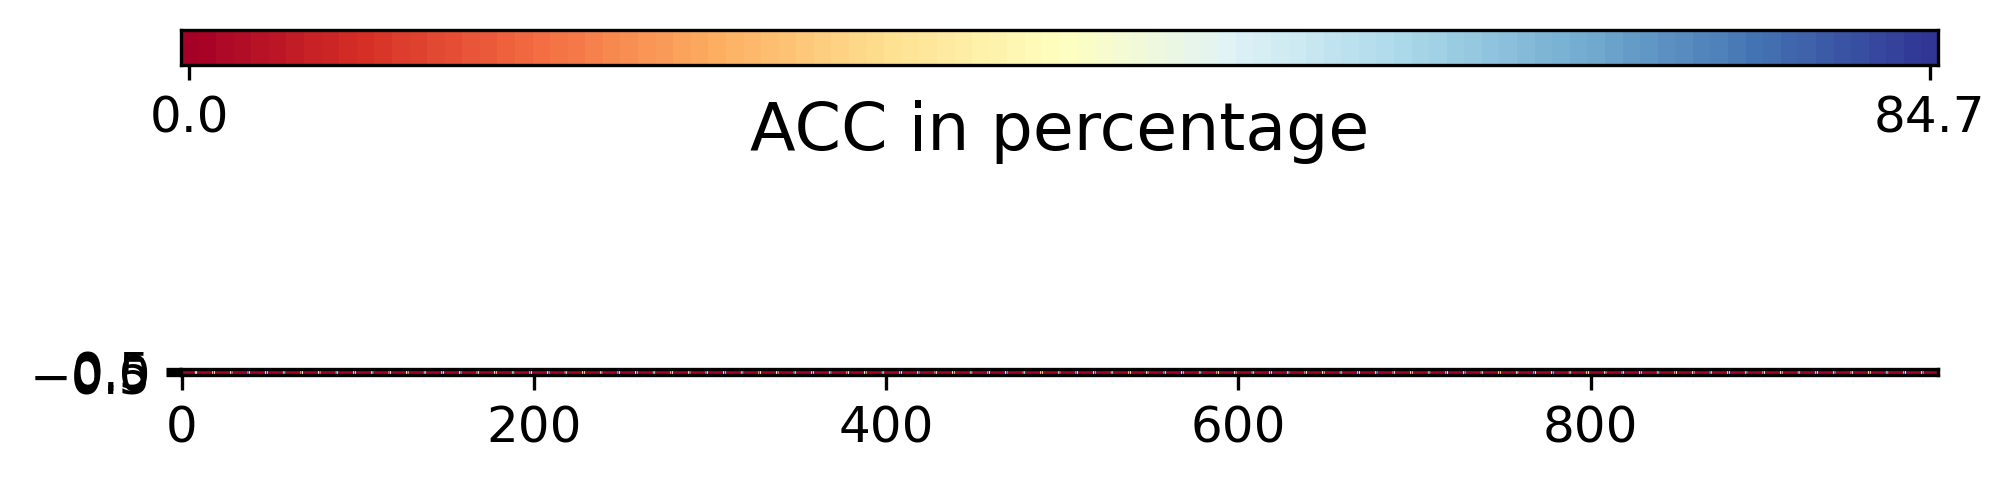

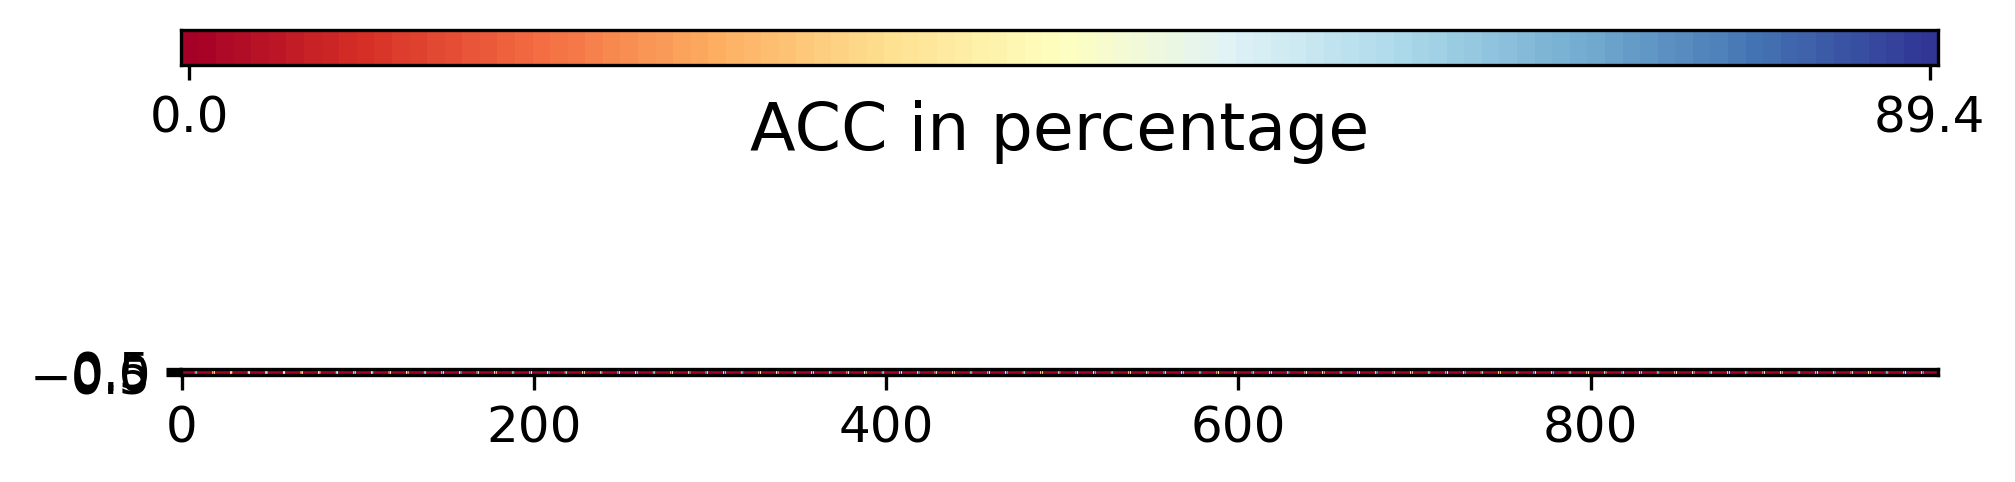

In [26]:
import matplotlib.pyplot as plt


def plot(title, data):
    width_half_inch, width_double_inch = 88.9 / 25.4, 182.0 / 25.4
    height_inch = 50 / 25.4
    scale = 2
    fig, ax = plt.subplots(2, 1, figsize=(width_half_inch * scale, height_inch * scale), dpi=300)
    fig.set_tight_layout(True)
    plt.rcParams.update({"font.size": 16})
    ax[1].tick_params(axis="both", which="major", labelsize=12)

    # Plot Matrix
    label_y = [str(k) for k in range(10, 101, 10)]
    label_x = [str(200)] + [str(int(j / 1000)) + "k" for j in range(300, data.shape[1] * 102, 100)]

    im = ax[1].imshow(data, cmap=sns.color_palette("RdYlBu", as_cmap=True))
    # ele = [0] + list(np.arange(8, 100, 10))

    # ax[1].set_xticks(ele)
    # ax[1].set_yticks(np.arange(len(label_y))[::2])

    # index = np.array([0] + list(np.arange(8, 100, 10)))
    # ax[1].set_xticklabels(np.array(label_x)[index])
    # ax[1].set_yticklabels(label_y[::2])

    ax[1].invert_yaxis()
    # ax[1].set_xlabel("Training Steps")
    # ax[1].set_ylabel("Data Percentage")

    plt.setp(ax[1].get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")
    ax[1].set_aspect(3.5)

    # Plot color bar
    nr = 100
    bar = np.arange(0, nr)[None]
    im = ax[0].imshow(bar, cmap=sns.color_palette("RdYlBu", as_cmap=True))
    ax[0].set_aspect(2)
    ax[0].set_xticks(np.array([0, nr - 1]))
    ax[0].set_yticks(np.array([]))
    ax[0].set_xticklabels(np.array([round(data.min() * 100, 1), round(data.max() * 100, 1)]))
    ax[0].set_yticklabels([])

    ax[1].tick_params(axis="both", which="major", labelsize=12)
    ax[1].tick_params(axis="both", which="minor", labelsize=12)
    ax[0].tick_params(axis="both", which="major", labelsize=12)
    ax[0].tick_params(axis="both", which="minor", labelsize=12)

    ax[0].set_xlabel("ACC in percentage")
    ax[0].xaxis.set_label_coords(0.5, -1)

    plt.subplots_adjust(hspace=-0.5)
    plt.show()
    fig.savefig("/tmp/img.png", dpi=300)


plot("Time/Data-Adaptation ACC GT", auroc_prop["forest"][:, 2:].mean(axis=2))
plot("Time/Data-Adaptation ACC GT", auroc_gt["forest"][:, 2:].mean(axis=2))

# plot("Time/Data-Adaptation ACC GT", auroc_prop["hilly"][:, 2:].mean(axis=2))
# plot("Time/Data-Adaptation ACC GT", auroc_gt["hilly"][:, 2:].mean(axis=2))
# plot("Time/Data-Adaptation AUCROC GT", auroc_prop["grassland"][:, 10:].mean(axis=2))
# plot("Time/Data-Adaptation AUCROC GT", auroc_gt["grassland"][:, 10:].mean(axis=2))